In [ ]:
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
%matplotlib inline

# Problem Statement

We have a set of images $\mathbf{X}$. Each image $\mathbf{x}$ from pen $i$ has exactly one non-zero element $x_i$. The value $x_i$ is the probablity of the image being accepted.

From $\mathbf{X}$, $N$ images are selected to be annotated. The annotation set is called $Ann$. The subset of $Ann$ pertain to pen $i$ is denoted as $Ann_i$.

The total number of images from $Ann$ expected to be accepted is

\begin{equation}
    \sum_{\mathbf{x} \in Ann} || \mathbf{x} ||
\end{equation}

The number of images from pen $i$ expected to be accepted is

\begin{equation}
    \sum_{\mathbf{x} \in Ann} x_i
\end{equation}

We refer to these values as $\mathit{KPI}$ and $\mathit{KPI_i}$ hereafter (an Aquabyte parlance?).

We introduce two constraint $l_{max}$ and $l_{min}$. $l_{max}$ cap the maximum value of $\mathit{KPI_i}$. Any acceptance above the limit has no utility. $l_{min}$, a new control, define the minimum number of acceptance to meet user's expectation. Here the constraints are global. A more general definition can have individual limit for each pen.

As the annotations are distributed among many pens, we want to avoid a problem where a subset of pens amass disproportional number of annotation resources and strave other pens. We define a per pen limit $l_{Ann_i}$ to denote the maximum number of annotation per pen. In practice, this quantity is best set as a multiplier to the average rather than an absolute count.

The problem can be defined as finding the optimal annotation set $Ann^*$

 
\begin{equation}
Ann^* = \underset{Ann}{argmax} \: \mathit{KPI}
\end{equation}

where 

$ l_{min} \le \mathit{KPI}_i \le l_{max} $ for all $i$

and 

$|Ann^*_k| \le l_{Ann_k}$ for all $k$.


# Test Dataset

In [ ]:
n = 500
m = 5
dataset = np.zeros((n,m))

def gen_probability(loc, scale):
    a = np.exp(-np.random.normal(loc=loc,scale=scale,size=n))
    return np.sort(a)[::-1]

dataset[:,0] = gen_probability(loc=1.7,scale=0.4)
dataset[:,1] = gen_probability(loc=2.1,scale=0.4)
dataset[:,2] = gen_probability(loc=2.4,scale=0.5)
dataset[:,3] = gen_probability(loc=2.9,scale=0.6)
dataset[:,4] = gen_probability(loc=3.4,scale=0.6)
np.median(dataset, axis=0)

In [ ]:
plt.title("Test Data")
sns.despine(bottom=True, left=True)
sns.stripplot(data=dataset, dodge=True, size=3, alpha=.3, zorder=1)
# plot medians
medians = [[x] for x in np.median(dataset, axis=0)]
sns.pointplot(data=medians, 
              dodge=.532, join=False, palette="dark",
              markers="D", scale=1, ci=None);


## Maximize expected total KPI

In [ ]:
N = 100
sorted_lin_idx = np.argsort(dataset, axis=None)
sorted_lin_idx = sorted_fidx[:-N-1:-1]
sorted_idx = np.unravel_index(sorted_fidx, dataset.shape)
steps = np.zeros((N, m))
steps[np.arange(N),sorted_idx[1]] = dataset[sorted_idx]
scores = np.cumsum(steps, axis=0)

In [ ]:
plt.title('Maximize total KPI')
sns.lineplot(data=scores);

## Maximize total KPI subject to $l_{max}$

In [ ]:
l_min = 1
l_max = 8
scores = np.zeros((N, m))

idx = np.zeros(m, dtype=int)
for i in range(N-1):
    next_step = dataset[idx, np.arange(m)]
    is_max = (scores[i] + next_step) > l_max
    next_step = next_step * np.logical_not(is_max)
    sel = np.argmax(next_step)
    scores[i+1] = scores[i]
    scores[i+1, sel] += next_step[sel]
    idx[sel] += 1
#scores

In [ ]:
plt.title('Maximize total KPI subject to $l_{max}$=%s' % l_max)
sns.lineplot(data=scores);

Compare with a progress chart from production dashboard

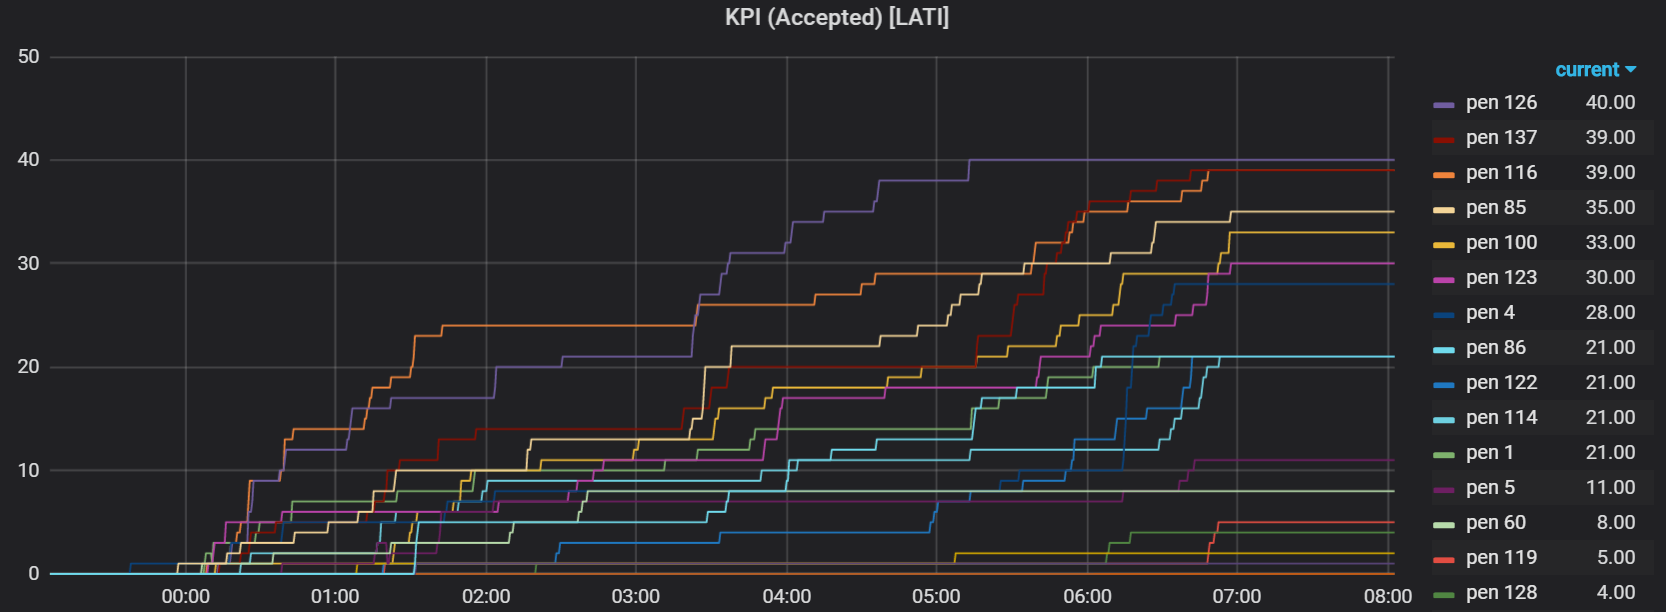

## Evaluate the Trade Off Using Two Pens

A simple model involves only two pens. We use this simple model to illustrate the trade off of different algorithm. It can also test the robustness of an algorithm under pathological situation by using some very bad pen.

In [ ]:
l_min = 1
l_max = 5
margin = 0.5

def gen_grid(s, margin=0.5):
    steps = np.cumsum(s)
    k = np.searchsorted(steps, l_max+margin)
    return steps[:k]
    
def gen_contour(s1, s2, N):
    contour = np.zeros((N+1,2))
    contour[1:,0] = np.cumsum(s1[:N])
    contour[:-1,1] = np.cumsum(s2[:N])[::-1]
    return contour
    
#contour = gen_contour(s1, s2, 20)

In [ ]:
def plot_row(ncols=1, nrows=1, fs=None, title=None):
    # chart size heuristic
    if fs is None:
        fs = 6 if ncols * nrows < 4 else 4
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*fs, nrows*fs))
    if title:
        fig.suptitle(title)
    # hack, don't squeeze 1x1 grid
    if ncols == 1 and nrows == 1:
        axs = [axs]
    return fig, axs
    
    
def plot_grid(ax, data, xlabel, ylabel):
    ax.set_xlim(0, l_max+margin)
    ax.set_ylim(0, l_max+margin)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for x in gen_grid(data[:,0]):
        ax.axvline(x, lw=1, c='#ccc')
    for y in gen_grid(data[:,1]):
        ax.axhline(y, lw=1, c='#ccc')
        
    alpha = 0.3
    ax.axhspan(0, l_min, color='#ccc', alpha=alpha)
    ax.axhspan(l_max, l_max+margin, color='#ccc', alpha=alpha)
    ax.axvspan(0, l_min, color='#ccc', alpha=alpha)
    ax.axvspan(l_max, l_max+margin, color='#ccc', alpha=alpha)

    
def plot_path(ax, scores):
    sns.lineplot(x=scores[:,0], y=scores[:,1], marker="o", estimator=None, ax=ax)
        

In [ ]:
data = dataset[:,[0,3]]
s1 = data[:,0]
s2 = data[:,1]

fig, axs = plot_row(1, title="Contours")
plot_grid(axs[0], data, "pen 0", "pen 3")

# contours
for k in range(5,45,5):
    contour = gen_contour(s1, s2, k)
    sns.lineplot(x=contour[:,0], y=contour[:,1], ax=axs[0], label="N=%s" % k)
    
axs[0].legend(loc="upper left");

In [ ]:
# algorithm

class RoundRobinSelector:
   
    def __init__(self):
        self.j = 0
       
    def select(self, k, next_step, is_min, is_max):
        m = len(next_step)
        for sel in ((self.j+k) % m for k in range(m)):
            if not is_max[sel]:
                break
        self.j = (sel+1) % m                
        return sel
    
    
class RatioSelector:
   
    def __init__(self, ratio):
        self.ratio = np.array(ratio)
       
    def select(self, k, next_step, is_min, is_max):
        m = len(next_step)
        ratio = self.ratio * np.logical_not(is_max)
        ratio /= ratio.sum()
        return np.random.choice(np.arange(m), p=ratio)

    
def select_best_first(k, next_step, is_min, is_max):
    next_step = next_step * np.logical_not(is_max)
    return np.argmax(next_step)


def select_min_then_best(k, next_step, is_min, is_max):
    if is_min.any():
        next_step = next_step * is_min
        return np.argmax(next_step)
    else:
        next_step = next_step * np.logical_not(is_max)
        return np.argmax(next_step)


def mix_min_and_best(k, next_step, is_min, is_max):
    if is_min.any() and (k % 2 == 0):
        next_step = next_step * is_min
        return np.argmax(next_step)
    else:
        next_step = next_step * np.logical_not(is_max)
        return np.argmax(next_step)
    

def run_selection(data, N, select_func):
    # data is (n x #series) array
    m = data.shape[1]
    scores = np.zeros((N, m))
    idx = np.zeros(m, dtype=int)
    
    for k in range(N-1):
        next_step = data[idx, np.arange(m)]
        is_min = scores[k] < l_min
        is_max = (scores[k] + next_step) > l_max
        
        sel = select_func(k, next_step, is_min, is_max)
        
        scores[k+1] = scores[k]
        scores[k+1, sel] += next_step[sel]
        idx[sel] += 1
        
    return scores

#run_selection(dataset, 10, RoundRobinSelector().select)

In [ ]:
N = 16

fig, axs = plot_row(2, title="Round Robin (N=%s)" % N)

# plot 1
data = dataset[:,[0,2]]
scores = run_selection(data, N, RoundRobinSelector().select)

plot_grid(axs[0], data, "pen 0", "pen 2")   
plot_path(axs[0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, RoundRobinSelector().select)

plot_grid(axs[1], data, "pen 0", "pen 4")   
plot_path(axs[1], scores)

In [ ]:
N = 15

fig, axs = plot_row(2, title="Choose Best (N=%s)" % N)

# plot 1
data = dataset[:,[0,2]]
scores = run_selection(data, N, select_best_first)

plot_grid(axs[0], data, "pen 0", "pen 2")
plot_path(axs[0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, select_best_first)

plot_grid(axs[1], data, "pen 0", "pen 4")   
plot_path(axs[1], scores)

In [ ]:
N = 16

fig, axs = plot_row(2, 2, title="Set Ratio (N=%s)" % N)

# plot 1
data = dataset[:,[0,1]]
scores = run_selection(data, N, RatioSelector([.25,.75]).select)

plot_grid(axs[0][0], data, "pen 0 - 25%", "pen 1 - 75%")
plot_path(axs[0][0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, RatioSelector([.25,.75]).select)

plot_grid(axs[0][1], data, "pen 0 - 25%", "pen 4 - 75%")   
plot_path(axs[0][1], scores)

# plot 1
data = dataset[:,[0,1]]
scores = run_selection(data, N, RatioSelector([.75,.25]).select)

plot_grid(axs[1][0], data, "pen 0 - 75%", "pen 1 - 25%")
plot_path(axs[1][0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, RatioSelector([.75,.25]).select)

plot_grid(axs[1][1], data, "pen 0 - 75%", "pen 4 - 25%")   
plot_path(axs[1][1], scores)


In [ ]:
N = 15

fig, axs = plot_row(2, title="Min, then Best (N=%s)" % N)

# plot 1
data = dataset[:,[0,2]]
scores = run_selection(data, N, select_min_then_best)

plot_grid(axs[0], data, "pen 0", "pen 2")
plot_path(axs[0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, select_min_then_best)

plot_grid(axs[1], data, "pen 0", "pen 4")   
plot_path(axs[1], scores)

In [ ]:
N = 16

fig, axs = plot_row(2, title="Mix Min and Best (N=%s)" % N)

# plot 1
data = dataset[:,[0,2]]
scores = run_selection(data, N, mix_min_and_best)

plot_grid(axs[0], data, "pen 0", "pen 2")
plot_path(axs[0], scores)

# plot 2
data = dataset[:,[0,4]]
scores = run_selection(data, N, mix_min_and_best)

plot_grid(axs[1], data, "pen 0", "pen 4")   
plot_path(axs[1], scores)

In [ ]:
# Test all algorithm

l_max = 8
l_min = 2
N = 80

fig, axs = plot_row(ncols=2, nrows=3, fs=6, title="ALL")

scores = run_selection(dataset, N, RoundRobinSelector().select)
axs[0][0].set_title("Round Robin")
sns.lineplot(data=scores, ax=axs[0][0]);

scores = run_selection(dataset, N, select_best_first)
axs[0][1].set_title("Choose Best")
sns.lineplot(data=scores, ax=axs[0][1]);

ratio = [.3,.3,.2,.1,.1]
scores = run_selection(dataset, N, RatioSelector(ratio).select)
axs[1][0].set_title('Fix Ratio=%s' % ratio)
sns.lineplot(data=scores, ax=axs[1][0]);

ratio = [.1,.1,.2,.3,.3]
scores = run_selection(dataset, N, RatioSelector(ratio).select)
axs[1][1].set_title('Fix Ratio=%s' % ratio)
sns.lineplot(data=scores, ax=axs[1][1]);

ratio = [.3,.3,.2,.1,.1]
scores = run_selection(dataset, N, select_min_then_best)
axs[2][0].set_title('Min then best; $l_{min}=%s$' % l_min)
sns.lineplot(data=scores, ax=axs[2][0]);

ratio = [.1,.1,.2,.3,.3]
scores = run_selection(dataset, N, mix_min_and_best)
axs[2][1].set_title('Mix min and best; $l_{min}=%s$' % l_min)
sns.lineplot(data=scores, ax=axs[2][1]);